##### **Imports**

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.stats import expon, norm
from scipy.optimize import minimize
from matplotlib.ticker import AutoMinorLocator

colors = ['crimson','midnightblue', 'magenta','orange','springgreen','dodgerblue','darkviolet', 'olive','tomato']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

##### **Problem 2a**

Get the data

In [70]:
columns_to_extract = ['lon', 'lat', 'crash_date']
dataframe = pd.read_csv('cpd-crash-incidents.csv', sep=';',usecols=columns_to_extract)

In [71]:
nan_count = dataframe['lon'].isna().sum()
non_nan_count = dataframe['lon'].notna().sum()

print(f"Number of NaN values is: {nan_count}")
print(f"Number of non-NaN values is: {non_nan_count}")

Number of NaN values is: 16779
Number of non-NaN values is: 6679


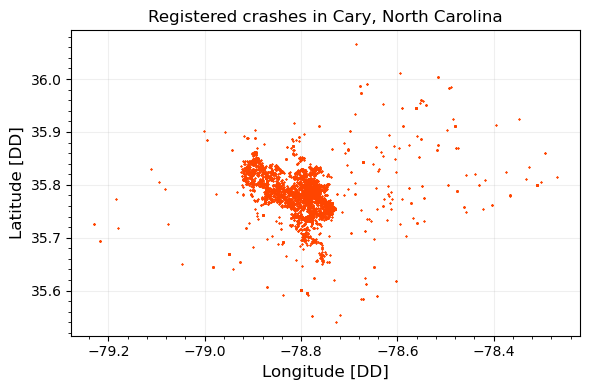

In [72]:
plt.figure(figsize = (6,4))

plt.scatter(dataframe['lon'],dataframe['lat'],s=0.5,marker='x',color='orangered')

ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='minor', length=2, color='k')

plt.title(f'Registered crashes in Cary, North Carolina',fontsize=12)
plt.xlabel('Longitude [DD]',fontsize=12)
plt.ylabel('Latitude [DD]',fontsize=12)
plt.grid(True,alpha=0.2,zorder=0)
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig('Problem2_Fig2a.pdf')
plt.show()

In [73]:
dataframe['crash_date'] = pd.to_datetime(dataframe['crash_date'])
dataframe['time_as_number'] = dataframe['crash_date'].dt.hour + dataframe['crash_date'].dt.minute/60 + dataframe['crash_date'].dt.second/3600

In [74]:
crashes_over_time = dataframe['time_as_number']

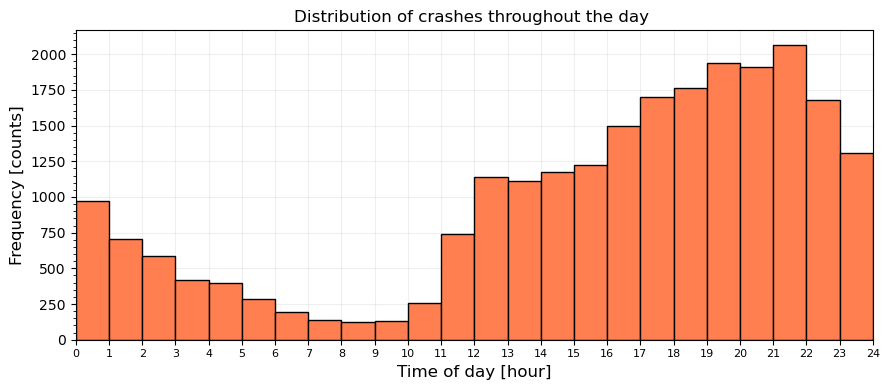

In [75]:
plt.figure(figsize = (9,4))

plt.hist(crashes_over_time,bins=np.arange(0,25,1),color='coral',edgecolor='black')

ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='minor', length=2, color='k')

plt.title(f'Distribution of crashes throughout the day ',fontsize=12)
plt.xlim(0,24)
plt.xticks(range(25), [str(i) for i in range(25)],fontsize=8)
plt.xlabel('Time of day [hour]',fontsize=12)
plt.ylabel('Frequency [counts]',fontsize=12)
plt.grid(True,alpha=0.2,zorder=0)
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig('Problem2_Fig2a_2.pdf')
plt.show()

##### Problem 2b

In [77]:
def epanechnikov_kernel(u):
    return 0.75 * (1 - u**2) if np.abs(u) <= 1 else 0

def circular_distance(time_point1, time_point2, cycle_length=24):
    distance = np.abs(time_point1 - time_point2)
    distance = np.minimum(distance, cycle_length - distance)
    return distance

def epanechnikov_KDE(data, x, bandwidth):
    N = len(data)
    cycle_length = 24
    estimate = np.sum([epanechnikov_kernel(circular_distance(x, xi, cycle_length) / bandwidth) for xi in data]) / (N * bandwidth)
    return estimate

In [78]:
h = 0.8 # Bandwidth

x_values = np.linspace(min(crashes_over_time) - h, max(crashes_over_time) + h, 1000)
density_estimates = [epanechnikov_KDE(crashes_over_time, x, h) for x in x_values]

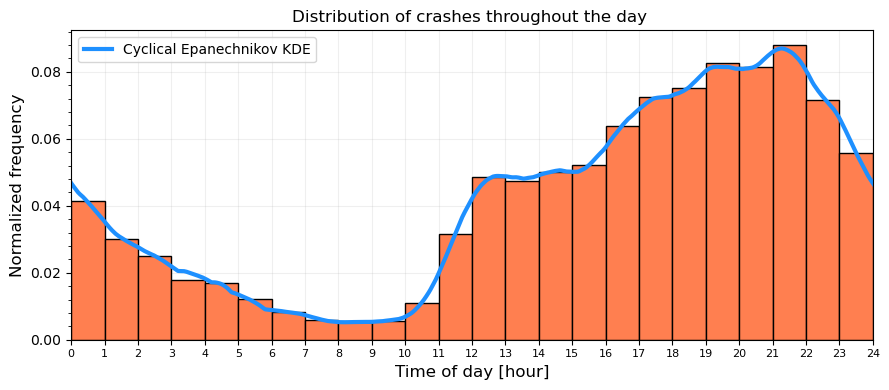

In [79]:
plt.figure(figsize = (9,4))

plt.hist(crashes_over_time,bins=np.arange(0,25,1),density=True,color='coral',edgecolor='black')
plt.plot(x_values, density_estimates, label='Cyclical Epanechnikov KDE',color = 'dodgerblue',linewidth=3)

ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='minor', length=2, color='k')

plt.title(f'Distribution of crashes throughout the day ',fontsize=12)
plt.xlim(0,24)
plt.xticks(range(25), [str(i) for i in range(25)],fontsize=8)
plt.xlabel('Time of day [hour]',fontsize=12)
plt.ylabel('Normalized frequency',fontsize=12)
plt.grid(True,alpha=0.2,zorder=0)
ax.set_axisbelow(True)
plt.tight_layout()
plt.legend(loc='best')
plt.savefig('Problem2_Fig2b.pdf')
plt.show()

In [80]:
times_to_evaluate = ["00:23", "01:49", "08:12", "15:55", "18:02", "21:12", "23:44"]
times_in_hours = [int(t.split(':')[0]) + int(t.split(':')[1]) / 60 for t in times_to_evaluate]
pdf_estimates = {t: epanechnikov_KDE(crashes_over_time, x, h) for t, x in zip(times_to_evaluate, times_in_hours)}

In [81]:
pdf_estimates

{'00:23': 0.04229811874026686,
 '01:49': 0.028548648280953284,
 '08:12': 0.005227371383353176,
 '15:55': 0.0564570251719829,
 '18:02': 0.07313700360867541,
 '21:12': 0.08688749578717245,
 '23:44': 0.051230008566087754}

In [87]:
# Define a function to find the best 2-hour window in the fine-grained density estimates
def find_best_patrol_window(density_estimates, interval_length=2, total_hours=24):
    # Calculate the number of points per hour
    points_per_hour = len(density_estimates) / total_hours
    
    # Calculate the number of points in 2 hours
    interval_points = int(points_per_hour * interval_length)
    
    # Initialize the maximum density sum and best interval start index
    max_density_sum = 0
    best_interval_start_index = 0
    
    # Slide a 2-hour window across the density estimates
    for i in range(len(density_estimates) - interval_points + 1):
        current_density_sum = np.sum(density_estimates[i:i+interval_points])
        if current_density_sum > max_density_sum:
            max_density_sum = current_density_sum
            best_interval_start_index = i
    
    # Calculate the reduction amount (10% of the density sum in the best window)
    reduction_amount = max_density_sum * 0.1
    
    # Calculate the percentage of the total density this reduction represents
    total_density = np.sum(density_estimates)
    reduction_percentage = (reduction_amount / total_density) * 100
    
    # Calculate the start and end times of the best 2-hour window
    best_interval_start_time = (best_interval_start_index / points_per_hour) % total_hours
    best_interval_end_time = (best_interval_start_time + interval_length) % total_hours
    
    return best_interval_start_time, best_interval_end_time, reduction_percentage

# Use the function to find the best patrol window
best_start_time, best_end_time, percent_reduction = find_best_patrol_window(density_estimates)

(best_start_time, best_end_time, percent_reduction)


(19.344, 21.344, 1.650477165792976)

##### Problem 2C